In [1]:
using LinearAlgebra
using Statistics
using IterativeSolvers
using Convex
using SCS
using COSMO
using NLsolve
using DifferentialEquations
using SparseArrays

using JLD2

using LightGraphs
using PyPlot
PyPlot.svg(true);

In [30]:
N = 6

g = LightGraphs.grid([N, N], periodic=false)
# g = LightGraphs.erdos_renyi(N^2, 0.35)
E = incidence_matrix(g; oriented=true)

# coupling constants
K = 2.0 # coupling scale
B = (K/mean(degree(g)))*ones(ne(g));

# laplacian
L = Symmetric(E*diagm(0=>B)*E')

u, Q = eigen(L)

L_sp = dropzeros(sparse(L))

# balanced power flows/natural frequencies
ω = randn(nv(g))
ω .-= mean(ω)
ω = ω./std(ω);

In [31]:
function f_steady_state(F, δ)
    F .= ω/nv(g) - E*(B.*sin.(E'*δ))
end

# initial condition
δ0 = 1e-2randn(nv(g))

sln = nlsolve(f_steady_state, δ0; autodiff=:forward)

@show converged(sln);

# order parameter at the fixed point
R0 = abs2(mean(exp.(1im*sln.zero)))

@show R0;

converged(sln) = true
R0 = 0.9969718690994027


In [32]:
# check by solving ODE
function f_kuramoto(du, u, p, t)
    f_steady_state(du, u)
end

# tspan = (0.0, 10.0)
# prob = ODEProblem(f_kuramoto, sln.zero + 5e-2randn(nv(g)), tspan)

# odesln = solve(prob, RK4())

# Rsqrss = [abs(mean(exp.(1im*u)))^2 for u in odesln.u]

f_kuramoto (generic function with 1 method)

In [33]:
# Noisy extension
δbar = sln.zero

# construct S matrix
h = complete_graph(nv(g))
Eh = incidence_matrix(h; oriented=true)
cosδbar = cos.(Eh'*δbar)

S = Symmetric(-Eh*diagm(0=>cosδbar)*Eh'/nv(g)^2)
# λ, Φ = eigen(S)

30×30 Symmetric{Float64, Matrix{Float64}}:
 -0.0319519    0.00111028   0.00110922  …   0.00109939   0.00109972
  0.00111028  -0.0320747    0.0011109       0.00110479   0.00110503
  0.00110922   0.0011109   -0.0321182       0.0011069    0.0011071
  0.00110821   0.00111048   0.001111        0.00110814   0.00110831
  0.00110769   0.00111023   0.00111088      0.00110863   0.00110878
  0.00109952   0.00110488   0.00110698  …   0.00111111   0.00111111
  0.00111111   0.00111022   0.00110913      0.00109917   0.0010995
  0.00111073   0.00111102   0.00111053      0.00110321   0.00110349
  0.00110803   0.0011104    0.00111097      0.00110832   0.00110848
  0.00110606   0.00110932   0.00111035      0.00110972   0.00110984
  0.00110323   0.00110751   0.00110905  …   0.00111073   0.00111079
  0.00109523   0.00110164   0.00110428      0.00111079   0.00111074
  0.00110958   0.001111     0.00111109      0.00110633   0.00110654
  ⋮                                     ⋱               
  0.00110549   0.0

In [34]:
# Eq = Convex.Variable(nv(g), nv(g))
# C = Convex.Variable(nv(g), nv(g))
Eq = Convex.Semidefinite(nv(g))
C = Convex.Semidefinite(nv(g))

# D = spdiagm(0 => u)
# St = Q'*S*Q

problem = maximize(tr(S*Eq), [
        L*Eq + Eq*L == C, 
#         eigmin(C) >= 0.0,
#         eigmin(Eq) >= 0.0,
        diag(C, 0) == 1.0,
#         tr(C) == nv(g),
        ])

maximize
└─ sum (affine; real)
   └─ diag (affine; real)
      └─ * (affine; real)
         ├─ …
         └─ …
subject to
├─ == constraint (affine)
│  ├─ + (affine; real)
│  │  ├─ * (affine; real)
│  │  │  ├─ …
│  │  │  └─ …
│  │  └─ * (affine; real)
│  │     ├─ …
│  │     └─ …
│  └─ 30×30 real variable (id: 176…337)
└─ == constraint (affine)
   ├─ diag (affine; real)
   │  └─ 30×30 real variable (id: 176…337)
   └─ 1.0

status: `solve!` not called yet

In [35]:
# Convex.solve!(problem, () -> SCS.Optimizer(verbose=true, max_iters=20000))
Convex.solve!(problem, () -> COSMO.Optimizer(verbose=true, 
        eps_abs=1e-6, eps_rel=1e-6, max_iter=50000))

------------------------------------------------------------------
          COSMO v0.8.1 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2021
------------------------------------------------------------------

Problem:  x ∈ R^{1801},
          constraints: A ∈ R^{2731x1801} (11281 nnz),
          matrix size to factor: 4532x4532,
          Floating-point precision: Float64
Sets:     ZeroSet) of dim: 1801
          DensePsdConeTriangle) of dim: 465
          DensePsdConeTriangle) of dim: 465
Settings: ϵ_abs = 1.0e-06, ϵ_rel = 1.0e-06,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 50000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{QRDecomp},
          Memory size = 15, RestartedMemory,	
          Safeguarded: t

3700	1.4006e-01	7.2975e-06	7.1990e-06	1.0000e-01
3725	1.4006e-01	7.2682e-06	7.1659e-06	1.0000e-01
3750	1.4006e-01	6.9267e-06	7.1720e-06	1.0000e-01
3775	1.4006e-01	6.6142e-06	7.1744e-06	1.0000e-01
3800	1.4006e-01	7.0838e-06	7.1519e-06	1.0000e-01
3825	1.4006e-01	8.8505e-06	7.1266e-06	1.0000e-01
3850	1.4006e-01	6.8194e-06	7.1141e-06	1.0000e-01
3875	1.4006e-01	6.8971e-06	7.0671e-06	1.0000e-01
3900	1.4006e-01	6.8959e-06	7.0784e-06	1.0000e-01
3925	1.4005e-01	8.4818e-06	7.0667e-06	1.0000e-01
3950	1.4005e-01	6.5233e-06	7.0207e-06	1.0000e-01
3975	1.4005e-01	6.3664e-06	6.9909e-06	1.0000e-01
4000	1.4005e-01	6.8970e-06	6.9782e-06	1.0000e-01
4025	1.4005e-01	6.7143e-06	6.9790e-06	1.0000e-01
4050	1.4005e-01	8.2904e-06	6.9408e-06	1.0000e-01
4075	1.4005e-01	5.5720e-06	6.9222e-06	1.0000e-01
4100	1.4005e-01	7.0041e-06	6.8521e-06	1.0000e-01
4125	1.4005e-01	6.5586e-06	6.7943e-06	1.0000e-01
4150	1.4005e-01	7.0135e-06	6.7672e-06	1.0000e-01
4175	1.4005e-01	9.4815e-06	6.6478e-06	1.0000e-01
4200	1.4005e-01	7.91

7900	1.4003e-01	6.0502e-07	2.1019e-06	1.0000e-01
7925	1.4003e-01	7.9054e-07	2.0894e-06	1.0000e-01
7950	1.4003e-01	9.7589e-07	2.0680e-06	1.0000e-01
7975	1.4003e-01	7.5989e-07	2.0570e-06	1.0000e-01
8000	1.4003e-01	1.3651e-06	2.0153e-06	1.0000e-01
8025	1.4003e-01	1.0108e-06	1.9320e-06	1.0000e-01

------------------------------------------------------------------
>>> Results
Status: Solved
Iterations: 8080 (incl. 55 safeguarding iter)
Optimal objective: 0.14
Runtime: 33.58s (33580.43ms)



In [36]:
# optimal solution
problem.optval

-0.14002840461808788

In [37]:
# sum(Q*Eq.value*Q'), sum(Q*C.value*Q')

In [38]:
# compare to uniform noise
C_unif = ((1 + 1/nv(g))I - ones(nv(g), nv(g))/nv(g))

E_uf = lyap(Array(L), -C_unif)

optval_uniform = tr(E_uf*S)

@show optval_uniform
@show optval_uniform/problem.optval

LoadError: LAPACKException(1)

In [39]:
# compare to uniform noise
C_unif = ((1 + 1/nv(g))I - ones(nv(g), nv(g))/nv(g))

# project on subspace 1^⟂
u, V = eigen(Array(L))

V0 = V[2:end,:]
L0 = V0*L*V0'
C0 = V0*C_unif*V0'
S0 = V0*S*V0'

E_uf = lyap(L0, -C0)

optval_uniform = tr(E_uf*S0)

@show optval_uniform
@show optval_uniform/problem.optval

optval_uniform = -0.42907741051874276
optval_uniform / problem.optval = 3.064216947190139


3.064216947190139

In [40]:
Copt = C.value
Eopt = Eq.value
optval = problem.optval

# jldsave("data/periodic_grid_$(N)x$(N)_fix_Cii.jld2"; g, K, B, δ0, sln, δbar, R0, Copt, Eopt, optval, optval_uniform)

-0.14002840461808788

In [41]:
diag(C.value)

30-element Vector{Float64}:
 0.9999999996214852
 0.9999999996312331
 1.0000000003294993
 1.0000000001356555
 0.9999999999528881
 0.9999999998117848
 0.9999999994375969
 0.9999999999542778
 0.999999999606858
 0.9999999999859348
 0.9999999999309163
 0.9999999999104715
 1.0000000033098781
 ⋮
 0.9999999996215124
 1.000000000124781
 0.9999999996974538
 1.0000000000760214
 0.9999999999311759
 1.000000000022853
 1.000000000083397
 0.9999999996420664
 1.0000000003222023
 1.0000000002079474
 1.000000000068733
 0.9999999997665345

In [42]:
@show eigvals(Symmetric(C.value))
@show eigvals(Symmetric(Eq.value));

eigvals(Symmetric(C.value)) = [-5.301017231029005e-6, -1.7464413044275626e-6, -4.5371521193949004e-7, -3.849784808681311e-7, -3.285478352188293e-7, -2.5416048980245876e-7, -1.6929292666659632e-7, -1.245135679423676e-7, -9.386381115155713e-8, -4.264734283769506e-8, -3.852204130728877e-8, -1.899682544738152e-8, 6.384342374004427e-8, 8.560743921518533e-8, 1.6700279859032054e-7, 1.8241011229748566e-7, 2.3341755004502199e-7, 2.94041154052286e-7, 3.9154292054581456e-7, 4.176885693949567e-7, 4.669577319152734e-7, 5.040935991066533e-7, 6.090670894645275e-7, 7.937547638296886e-7, 1.2127598634749102e-6, 1.4343436837063913e-6, 4.8586118674980955e-6, 0.02252344810722793, 0.4336106853981755, 29.543863111628976]
eigvals(Symmetric(Eq.value)) = [-3.0024283336467887e-7, -9.009753023034573e-8, -4.819435281755113e-8, -3.160926372075686e-8, -2.1699558906625924e-8, -4.8430642879885274e-9, 3.961336408526329e-10, 1.1095110699183186e-8, 4.8821079231246314e-8, 6.596140690531762e-8, 7.714958211856835e-8, 8.9359

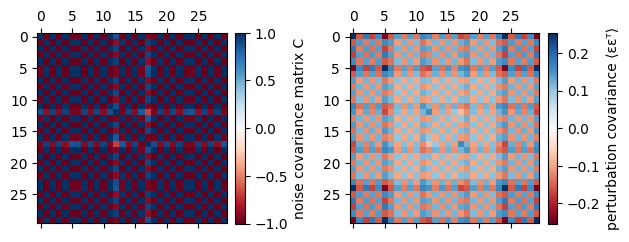

In [43]:
fig, axs = subplots(1, 2)

ax = axs[1]
cmin, cmax = abs(minimum(C.value)), abs(maximum(C.value))
cm = maximum([cmin, cmax])
sc = ax.matshow(C.value, cmap="RdBu", vmin=-cm, vmax=cm)
fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label="noise covariance matrix C")

ax = axs[2]
cmin, cmax = abs(minimum(Eq.value)), abs(maximum(Eq.value))
cm = maximum([cmin, cmax])
sc = ax.matshow(Eq.value, cmap="RdBu", vmin=-cm, vmax=cm)
fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label="perturbation covariance ⟨εεᵀ⟩")

fig.tight_layout()

In [149]:
# find a particular realization of the noise input
function G_from_C(C)
    U, Σ, V = svd(C)
    U*diagm(0 => sqrt.(Σ))*U'
end

G = G_from_C(Q*C.value*Q')
η = G*randn(nv(g));

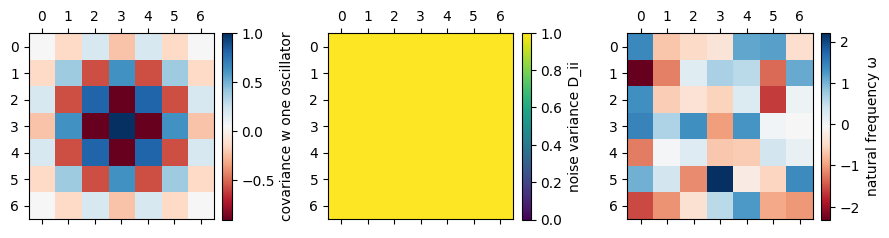

In [150]:
# visualization for grid graphs

fig, axs = subplots(1, 3, figsize=(9, 3))

ax = axs[1]
# sc = ax.matshow(reshape(η, N, N)', cmap="RdBu")
# fig.colorbar(sc, ax=ax, label="noise strength η(t)", fraction=0.046, pad=0.04)

sc = ax.matshow(reshape(C.value[3N+4,:], N, N)', cmap="RdBu")
fig.colorbar(sc, ax=ax, label="covariance w one oscillator", fraction=0.046, pad=0.04)

ax = axs[2]
sc = ax.matshow(reshape(diag(C.value), N, N)', cmap="viridis", vmin=0)
fig.colorbar(sc, ax=ax, label="noise variance D_ii", fraction=0.046, pad=0.04)

ax = axs[3]
sc = ax.matshow(reshape(ω, N, N)', cmap="RdBu")
fig.colorbar(sc, ax=ax, label="natural frequency ω", fraction=0.046, pad=0.04)

fig.tight_layout()

In [62]:
# run a SDE solution to check results

function solve_sde(σ, δ0, G; tspan=(0.0, 3000.0), dt=0.001)
    # σ is the noise strength (multiplies the noise matrix)
    function g_kuramoto(du, u, p, t)
        du .= σ*G
    end
    
    prob = SDEProblem(f_kuramoto, g_kuramoto, δ0, tspan; noise_rate_prototype=zeros(size(G)...))
    sdesln = solve(prob, LambaEM(), dt=dt)
end

function cumtrapz_avg(t::T, Y::T) where {T <: AbstractVector}
    # Estimates the cumulative time average integral 1/T ∫₀ᵀ f(t) dt using the trapezoid rule
    # where time points are in t and corresponding samples of f are in Y
    
    # Check matching vector length
    @assert length(t) == length(Y)
    
    # Initialize Output
    out = similar(t)
    out[1] = 0.0
    # Iterate over arrays
    for i in 2:length(t)
        out[i] = out[i-1] + 0.5*(t[i] - t[i-1])*(Y[i] + Y[i-1])
    end
    out[2:end] ./= (t[2:end] .- t[1])
    out[1] = out[2]

    out
end

function Rsqr_from_sde(sdesln)
    # numerically integrate and average
    Rsqrs = [abs(mean(exp.(1im*u)))^2 for u in sdesln.u]
end

Rsqr_from_sde (generic function with 1 method)

In [63]:
σ = 0.001
sdesln = solve_sde(σ, sln.zero, G; tspan=(0.0, 20000.0))
Rsqrs_sde = Rsqr_from_sde(sdesln);
Rsqrs_avg = cumtrapz_avg(sdesln.t, Rsqrs_sde);

In [64]:
G_unif = G_from_C(C_unif)

sdesln_unif = solve_sde(σ, sln.zero, G_unif; tspan=(0.0, 20000.0))
Rsqrs_sde_unif = Rsqr_from_sde(sdesln_unif);
Rsqrs_avg_unif = cumtrapz_avg(sdesln_unif.t, Rsqrs_sde_unif);

In [65]:
# fig, ax = subplots()
# ax.plot(sdesln.t, hcat(sdesln.u...)')
# # ax.axhline(R0, ls=":")
# # ax.plot(Rsqrss)

# ax.set_xlabel("time t")
# ax.set_ylabel("θ")

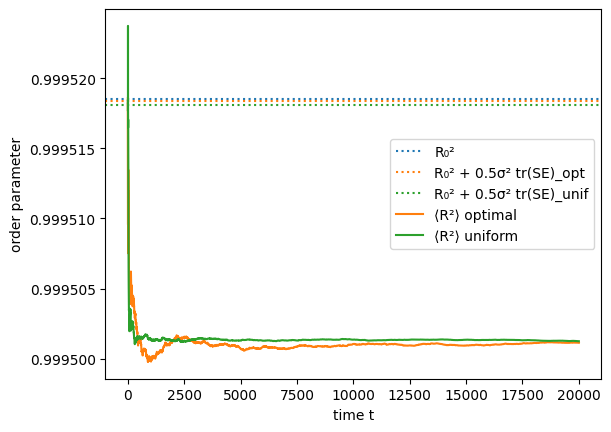

PyObject Text(24.0, 0.5, 'order parameter')

In [66]:
fig, ax = subplots()
ax.axhline(R0, ls=":", label="R₀²")
ax.axhline(R0 + σ^2*problem.optval, label="R₀² + 0.5σ² tr(SE)_opt", color="C1", ls=":")
ax.axhline(R0 + σ^2*optval_uniform, label="R₀² + 0.5σ² tr(SE)_unif", color="C2", ls=":")
# ax.axhline(R0 - σ^2*problem.optval)

# ax.set_ylim(R0 - 5σ^2*abs(optval_uniform), R0 + 5σ^2*abs(optval_uniform))

# ax.plot(Rsqrs_sde, alpha=0.5)
ax.plot(sdesln.t, Rsqrs_avg, color="C1", label="⟨R²⟩ optimal")
ax.plot(sdesln_unif.t, Rsqrs_avg_unif, color="C2", label="⟨R²⟩ uniform")

# ax.set_xlim(150000, 200000)

ax.legend()
ax.set_xlabel("time t")
ax.set_ylabel("order parameter")

In [155]:
function noise_compare(σ_max, n)
    Rsqrs_opt = []
    Rsqrs_uni = []
    σs = LinRange(0, σ_max, n)
    
    for σ in σs
        sdesln = solve_sde(σ, sln.zero, G; tspan=(0.0, 1000.0))
        Rsqrs_sde = Rsqr_from_sde(sdesln);
        Rsqrs_avg = cumtrapz_avg(sdesln.t, Rsqrs_sde);
        
        push!(Rsqrs_opt, Rsqrs_avg[end])
        
        sdesln_unif = solve_sde(σ, sln.zero, G_unif; tspan=(0.0, 1000.0))
        Rsqrs_sde_unif = Rsqr_from_sde(sdesln_unif);
        Rsqrs_avg_unif = cumtrapz_avg(sdesln_unif.t, Rsqrs_sde_unif);        
        
        push!(Rsqrs_uni, Rsqrs_avg_unif[end])
    end
    
    σs, Rsqrs_opt, Rsqrs_uni
end

noise_compare (generic function with 1 method)

In [156]:
σs, Rsqrs_opt, Rsqrs_uni = noise_compare(5.0, 30)

(range(0.0, stop=5.0, length=30), Any[0.9775165930968239, 0.9767083997223123, 0.9744544640752252, 0.9707811232782676, 0.9656391661249528, 0.958328686453594, 0.9442885186127457, 0.9372121639094788, 0.9205040677482957, 0.8875732038413892  …  0.10991010013153488, 0.08493392272771721, 0.07744134307045566, 0.07685599167316745, 0.06584846947200189, 0.06068499214783806, 0.051395314541630696, 0.05237576304924391, 0.04295949646210143, 0.04485452212232592], Any[0.9775165930968239, 0.9740077477689395, 0.9654441213427184, 0.9514798304794789, 0.9320393602907283, 0.9059490582222319, 0.8744040074086908, 0.8383203141790625, 0.7929276196395421, 0.7429798092531319  …  0.041609792497919254, 0.03351163101663043, 0.029127247653350362, 0.02702595263012362, 0.025077274658326452, 0.02383783009578807, 0.021883116568903644, 0.021752091044680146, 0.020344530642554252, 0.019895915810314253])

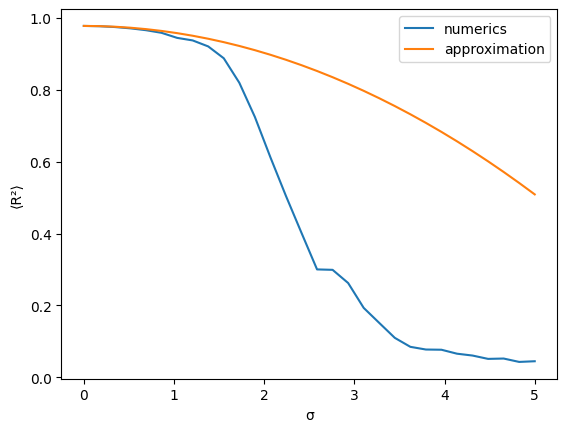

PyObject Text(24.000000000000007, 0.5, '⟨R²⟩')

In [157]:
fig, ax = subplots()

ax.plot(σs, Rsqrs_opt, label="numerics")
# ax.plot(σs, Rsqrs_uni)
ax.plot(σs, map(σ ->  R0 + σ^2*problem.optval, σs), label="approximation")

ax.legend()
ax.set_xlabel("σ")
ax.set_ylabel("⟨R²⟩")